In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.ticker as ticker
import warnings
import itertools
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

def load_data(file_path):
    df = pd.read_csv(file_path)
    if "Year" in df.columns:
        df['Year'] = df['Year'].astype(int)  # Make sure Year is int
    if "Personal Income" in df.columns:
        df["Personal Income"] = df["Personal Income"].apply(lambda x: x.replace("$", "\\$"))
    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# ARIMA forecast
def arima_forecast(series, order, steps=5):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    conf_int = model_fit.get_forecast(steps=steps).conf_int()
    lower = conf_int.iloc[:, 0].values
    upper = conf_int.iloc[:, 1].values
    return forecast, lower, upper

# adds commas to y-axis.. was a pain to format
def format_y_axis_plain(ax, is_millions=False):
    if is_millions:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, p: f'{x/1000000:.1f}M'))
    else:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, p: f'{x:,.0f}'))

def format_y_axis_dollars(ax, is_millions=False):
    if is_millions:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, p: f'${x/1000000:.1f}M'))
    else:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, p: f'${x:,.0f}'))

# find best arima params (full process of using AIC values used to determine best params)
def find_best_arima(series, max_p=2, max_d=2, max_q=2):
    best_aic = float('inf')
    best_order = None
    
    # check if stationary
    result = adfuller(series.values)
    p_value = result[1]
    
    # min d based on stationarity
    min_d = 0 if p_value < 0.05 else 1
    
    # try diff p,d,q combos
    for p, d, q in itertools.product(range(max_p+1), 
                                    range(min_d, max_d+1), 
                                    range(max_q+1)):
        if p == 0 and q == 0:
            continue  # skip invalid model
        
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue
    
    # default if fails
    if best_order is None:
        best_order = (1, 1, 1)
        
    return best_order

income_order = [
    "No Income",
    "\\$5,000 to \\$9,999",
    "\\$10,000 to \\$14,999",
    "\\$15,000 to \\$24,999",
    "\\$25,000 to \\$34,999",
    "\\$35,000 to \\$49,999",
    "\\$50,000 to \\$74,999",
    "\\$75,000 and over",
]

def reorder_column(df, col, order):
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)
    df = df.sort_values(by=col).reset_index(drop=True)
    return df

In [2]:
def analyze_zillow_data(file_path, forecast_years=3):
    # load data
    df = load_data(file_path)
    
    # debug column names
    print("available columns:", df.columns.tolist())
    
    # process data
    # convert date if it exists
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        
        # get year if needed
        if 'Year' not in df.columns:
            df['Year'] = df['Date'].dt.year
    
    # check for monthyear instead
    elif 'MonthYear' in df.columns:
        df['Date'] = pd.to_datetime(df['MonthYear'])
        df['Year'] = df['Date'].dt.year
    
    # fallback for year column
    if 'Year' not in df.columns:
        # try date-like columns
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'year' in col.lower() or 'month' in col.lower()]
        if date_cols:
            try:
                df['Date'] = pd.to_datetime(df[date_cols[0]])
                df['Year'] = df['Date'].dt.year
            except:
                # last resort
                print(f"warning: no date column found. making up years.")
                df['Year'] = 2012 + (df.index % 14)  # fake years 2012-2025
    
    # find zhvi column
    zhvi_col = 'ZHVI'
    if zhvi_col not in df.columns:
        # look for value/price columns
        value_cols = [col for col in df.columns if any(x in col.lower() for x in ['value', 'price', 'zhvi'])]
        if value_cols:
            zhvi_col = value_cols[0]
            print(f"using '{zhvi_col}' as ZHVI column")
        else:
            # use first numeric column
            numeric_cols = df.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                zhvi_col = numeric_cols[0]
                print(f"using '{zhvi_col}' as ZHVI column")
            else:
                print("error: no value column found")
                return
                
    # check for income column
    income_col = 'Income Needed'
    if income_col not in df.columns:
        # try alternatives
        alt_names = ['IncomeNeeded', 'Income', 'IncomeRequired', 'RequiredIncome']
        for name in alt_names:
            if name in df.columns:
                income_col = name
                print(f"using '{income_col}' for Income")
                break
    
    # get top regions by current zhvi
    latest_year = df['Year'].max()
    top_regions = df[df['Year'] == latest_year].groupby("RegionName").mean("ZHVI").nlargest(5,"ZHVI").index.unique()
    
    # get years for plotting
    years = sorted(df['Year'].unique())
    max_year = max(years)
    future_years = list(range(max_year+1, max_year+forecast_years+1))
    
    # create 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.subplots_adjust(wspace=0.2)
    
    colors = plt.cm.tab10.colors
    
    best_orders = {}
    
    # plt1: ZHVI by Region (Left)
    ax = axes[0]
    
    # for each region
    for i, region in enumerate(top_regions):
        # get data
        region_data = df[df['RegionName'] == region]
        yearly_data = region_data.groupby('Year')[zhvi_col].mean()
        
        if len(yearly_data) < 4:
            print(f"warning: not enough data for {region}. skipping.")
            continue
        
        # find best arima params
        try:
            order = find_best_arima(yearly_data)
            best_orders[f"{region}_ZHVI"] = order
        except:
            order = (1, 1, 1)  # default
            best_orders[f"{region}_ZHVI"] = order
            print(f"using default model for {region}: {order}")
            
        # plot historical data
        ax.plot(yearly_data.index, yearly_data.values, 'o-', 
                color=colors[i % len(colors)], linewidth=2, 
                label=f"{region}")
        
        # forecast
        try:
            forecast, lower, upper = arima_forecast(yearly_data, order, steps=forecast_years)
            
            # plot forecast
            ax.plot(future_years, forecast, 'x--', color=colors[i % len(colors)], 
                    linewidth=1.5, alpha=0.7)
            
            # confidence interval
            ax.fill_between(future_years, lower, upper, color=colors[i % len(colors)], 
                        alpha=0.1)
        except Exception as e:
            print(f"error forecasting {region}: {e}")
    
    ax.set_title('Zillow Home Value Index (ZHVI) Forecasts', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=14)
    ax.set_ylabel('Home Value ($)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=12)
    
    # vertical line for forecast start
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=12)
    
    # integer ticks on x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_dollars(ax, is_millions=True)
    
    # plt2: Income Needed by Region (Right)
    ax = axes[1]
    
    # for each region
    for i, region in enumerate(top_regions):
        # get data
        region_data = df[df['RegionName'] == region]
        yearly_data = region_data.groupby('Year')[income_col].mean()
        
        if len(yearly_data) < 4:
            continue
        
        # find best arima params
        try:
            order = find_best_arima(yearly_data)
            best_orders[f"{region}_{income_col}"] = order
        except:
            order = (1, 1, 1)  # default
            best_orders[f"{region}_{income_col}"] = order
            
        # plot historical data
        ax.plot(yearly_data.index, yearly_data.values, 'o-', 
                color=colors[i % len(colors)], linewidth=2, 
                label=f"{region}")
        
        # forecast
        try:
            forecast, lower, upper = arima_forecast(yearly_data, order, steps=forecast_years)
            
            # plot forecast
            ax.plot(future_years, forecast, 'x--', color=colors[i % len(colors)], 
                    linewidth=1.5, alpha=0.7)
            
            # confidence interval
            ax.fill_between(future_years, lower, upper, color=colors[i % len(colors)], 
                        alpha=0.1)
        except Exception as e:
            print(f"error forecasting {region} {income_col}: {e}")
    
    ax.set_title('Income Needed Forecasts', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=14)
    ax.set_ylabel('Income Needed ($)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=12)
    
    # vertical line for forecast start
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=12)
    
    # integer ticks on x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_dollars(ax)
    
    # data source note.. again thought it was a nice touch
    plt.figtext(0.5, 0.01, 
                "data source: zillow.csv | arima time series modeling", 
                ha="center", fontsize=12, style='italic')
    
    plt.suptitle('California Housing Market ARIMA Forecasts (2012-2028)', 
                fontsize=20, fontweight='bold')
    plt.figtext(0.5, 0.93, 
                "projected housing values and income requirements", 
                ha="center", fontsize=16)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    plt.show()
    
    # print model details
    print("\nbest arima parameters:")
    for name, order in best_orders.items():
        print(f"{name}: ARIMA{order}")
    
    return best_orders

In [3]:
def save_fig_zillow(file_path, save_img_path, forecast_years=3):
    # load data    
    figsize=(7,5)
    df = load_data(file_path)

    # process data
    # convert date if it exists
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])

        # get year if needed
        if 'Year' not in df.columns:
            df['Year'] = df['Date'].dt.year

    # check for monthyear instead
    elif 'MonthYear' in df.columns:
        df['Date'] = pd.to_datetime(df['MonthYear'])
        df['Year'] = df['Date'].dt.year

    # fallback for year column
    if 'Year' not in df.columns:
        # try date-like columns
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'year' in col.lower() or 'month' in col.lower()]
        if date_cols:
            try:
                df['Date'] = pd.to_datetime(df[date_cols[0]])
                df['Year'] = df['Date'].dt.year
            except:
                # last resort
                print(f"warning: no date column found. making up years.")
                df['Year'] = 2012 + (df.index % 14)  # fake years 2012-2025

    # find zhvi column
    zhvi_col = 'ZHVI'
    if zhvi_col not in df.columns:
        # look for value/price columns
        value_cols = [col for col in df.columns if any(x in col.lower() for x in ['value', 'price', 'zhvi'])]
        if value_cols:
            zhvi_col = value_cols[0]
            print(f"using '{zhvi_col}' as ZHVI column")
        else:
            # use first numeric column
            numeric_cols = df.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                zhvi_col = numeric_cols[0]
                print(f"using '{zhvi_col}' as ZHVI column")
            else:
                print("error: no value column found")
                return

    # check for income column
    income_col = 'Income Needed'
    if income_col not in df.columns:
        # try alternatives
        alt_names = ['IncomeNeeded', 'Income', 'IncomeRequired', 'RequiredIncome']
        for name in alt_names:
            if name in df.columns:
                income_col = name
                print(f"using '{income_col}' for Income")
                break

    # get top regions by current zhvi
    latest_year = df['Year'].max()
    top_regions = df[df['Year'] == latest_year].groupby("RegionName").mean("ZHVI").nlargest(5,"ZHVI").index.unique()

    # get years for plotting
    years = sorted(df['Year'].unique())
    max_year = max(years)
    future_years = list(range(max_year+1, max_year+forecast_years+1))

    colors = plt.cm.tab10.colors

    best_orders = {}

    # Plot and save ZHVI by Region
    fig, ax = plt.subplots(figsize=figsize)

    # for each region
    for i, region in enumerate(top_regions):
        # get data
        region_data = df[df['RegionName'] == region]
        yearly_data = region_data.groupby('Year')[zhvi_col].mean()

        if len(yearly_data) < 4:
            print(f"warning: not enough data for {region}. skipping.")
            continue

        # find best arima params
        try:
            order = find_best_arima(yearly_data)
            best_orders[f"{region}_ZHVI"] = order
        except:
            order = (1, 1, 1)  # default
            best_orders[f"{region}_ZHVI"] = order
            print(f"using default model for {region}: {order}")

        # plot historical data
        ax.plot(yearly_data.index, yearly_data.values, 'o-',
                color=colors[i % len(colors)], linewidth=2,
                label=f"{region}")

        # forecast
        try:
            forecast, lower, upper = arima_forecast(yearly_data, order, steps=forecast_years)

            # plot forecast
            ax.plot(future_years, forecast, 'x--', color=colors[i % len(colors)],
                    linewidth=1.5, alpha=0.7)

            # confidence interval
            ax.fill_between(future_years, lower, upper, color=colors[i % len(colors)],
                        alpha=0.1)
        except Exception as e:
            print(f"error forecasting {region}: {e}")

    ax.set_title('Zillow Home Value Index (ZHVI) Forecasts',
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=14)
    ax.set_ylabel('Home Value ($)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=12)

    # vertical line for forecast start
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=12)

    # integer ticks on x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_dollars(ax, is_millions=True)



    plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust layout to make space for the note
    plt.savefig(f'{save_img_path}/zhvi_forecasts.png')
    plt.close(fig)

    # Plot and save Income Needed by Region
    fig, ax = plt.subplots(figsize=figsize)

    # for each region
    for i, region in enumerate(top_regions):
        # get data
        region_data = df[df['RegionName'] == region]
        yearly_data = region_data.groupby('Year')[income_col].mean()

        if len(yearly_data) < 4:
            continue

        # find best arima params
        try:
            order = find_best_arima(yearly_data)
            best_orders[f"{region}_{income_col}"] = order
        except:
            order = (1, 1, 1)  # default
            best_orders[f"{region}_{income_col}"] = order

        # plot historical data
        ax.plot(yearly_data.index, yearly_data.values, 'o-',
                color=colors[i % len(colors)], linewidth=2,
                label=f"{region}")

        # forecast
        try:
            forecast, lower, upper = arima_forecast(yearly_data, order, steps=forecast_years)

            # plot forecast
            ax.plot(future_years, forecast, 'x--', color=colors[i % len(colors)],
                    linewidth=1.5, alpha=0.7)

            # confidence interval
            ax.fill_between(future_years, lower, upper, color=colors[i % len(colors)],
                        alpha=0.1)
        except Exception as e:
            print(f"error forecasting {region} {income_col}: {e}")

    ax.set_title('Income Needed Forecasts',
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=14)
    ax.set_ylabel('Income Needed ($)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=12)

    # vertical line for forecast start
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=12)

    # integer ticks on x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_dollars(ax)


    plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust layout
    plt.savefig(f'{save_img_path}/income_needed_forecasts.png')
    plt.close(fig)

    # print model details (optional, kept from original)
    print("\nbest arima parameters:")
    for name, order in best_orders.items():
        print(f"{name}: ARIMA{order}")

    return best_orders

Loaded data with 4056 rows and 4 columns
available columns: ['RegionName', 'Date', 'ZHVI', 'Income Needed']


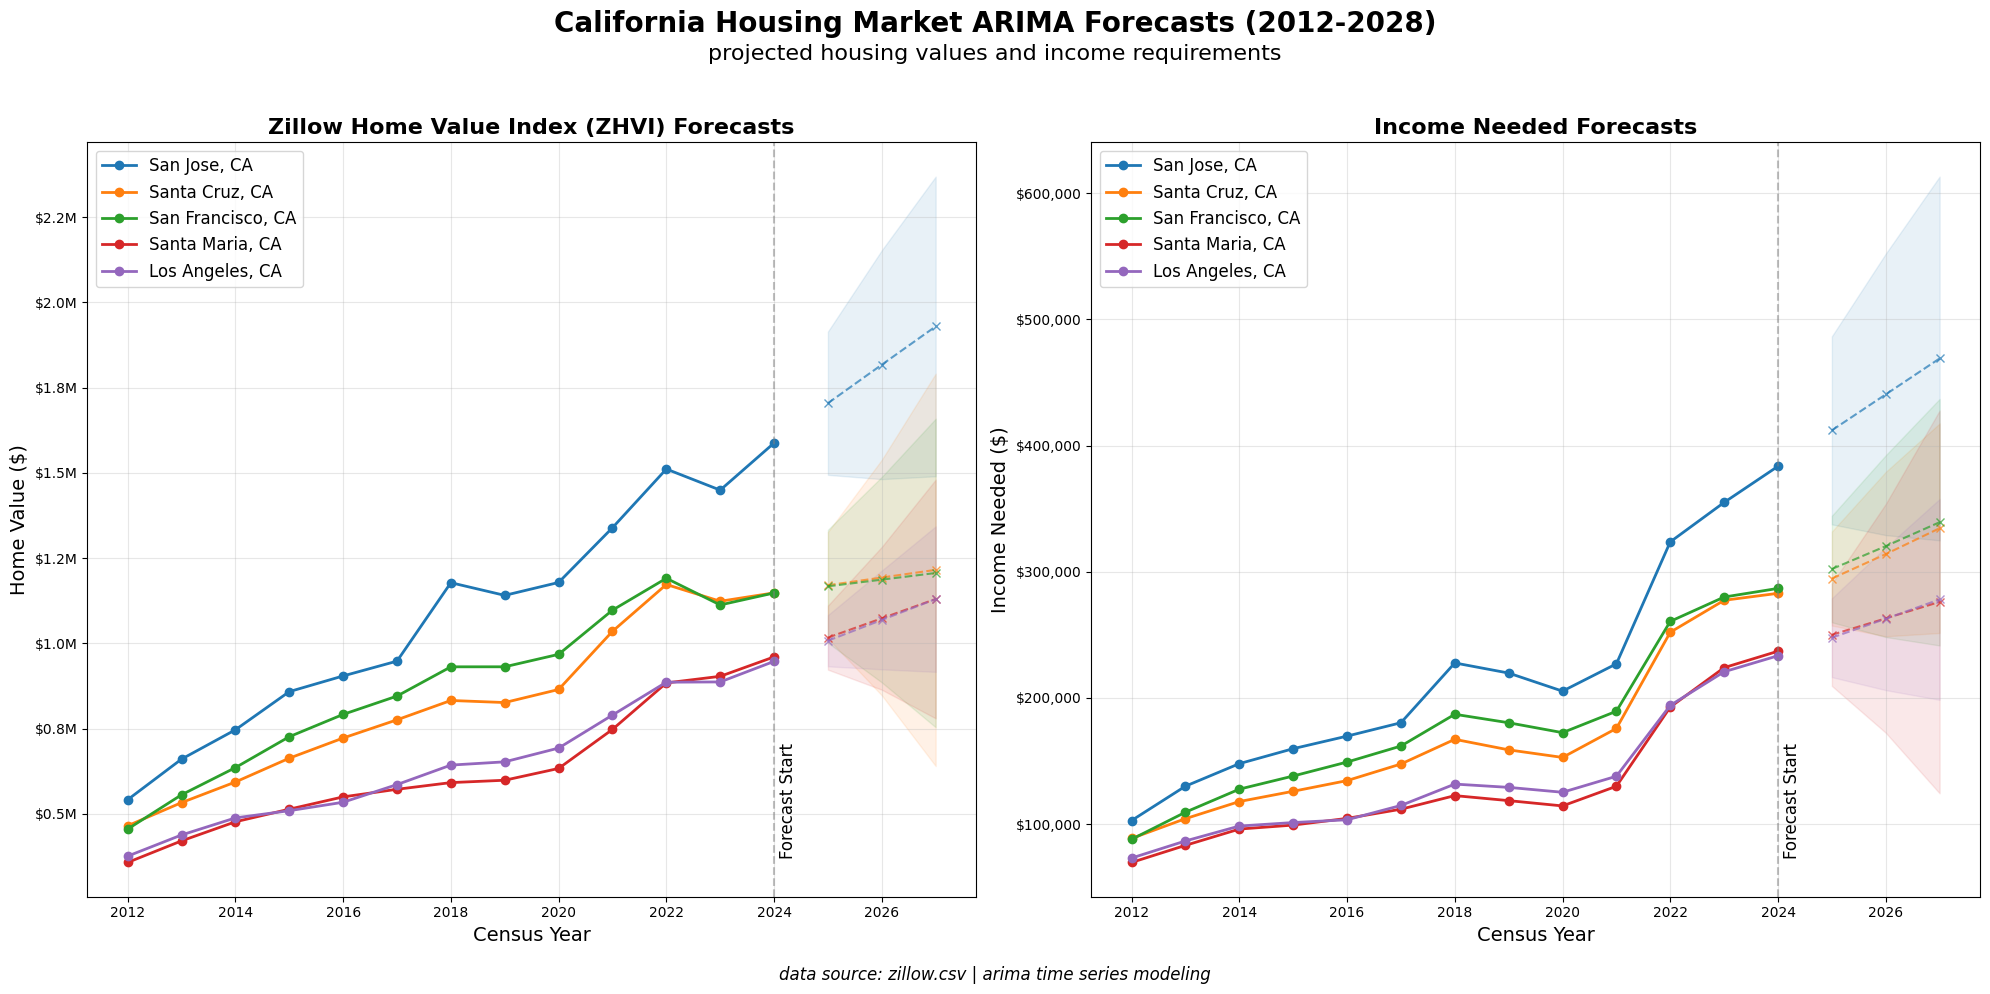


best arima parameters:
San Jose, CA_ZHVI: ARIMA(1, 2, 1)
Santa Cruz, CA_ZHVI: ARIMA(1, 2, 0)
San Francisco, CA_ZHVI: ARIMA(0, 2, 1)
Santa Maria, CA_ZHVI: ARIMA(1, 2, 0)
Los Angeles, CA_ZHVI: ARIMA(1, 2, 1)
San Jose, CA_Income Needed: ARIMA(0, 2, 1)
Santa Cruz, CA_Income Needed: ARIMA(2, 2, 1)
San Francisco, CA_Income Needed: ARIMA(1, 2, 1)
Santa Maria, CA_Income Needed: ARIMA(1, 2, 0)
Los Angeles, CA_Income Needed: ARIMA(1, 2, 1)
Loaded data with 4056 rows and 4 columns

best arima parameters:
San Jose, CA_ZHVI: ARIMA(1, 2, 1)
Santa Cruz, CA_ZHVI: ARIMA(1, 2, 0)
San Francisco, CA_ZHVI: ARIMA(0, 2, 1)
Santa Maria, CA_ZHVI: ARIMA(1, 2, 0)
Los Angeles, CA_ZHVI: ARIMA(1, 2, 1)
San Jose, CA_Income Needed: ARIMA(0, 2, 1)
Santa Cruz, CA_Income Needed: ARIMA(2, 2, 1)
San Francisco, CA_Income Needed: ARIMA(1, 2, 1)
Santa Maria, CA_Income Needed: ARIMA(1, 2, 0)
Los Angeles, CA_Income Needed: ARIMA(1, 2, 1)


{'San Jose, CA_ZHVI': (1, 2, 1),
 'Santa Cruz, CA_ZHVI': (1, 2, 0),
 'San Francisco, CA_ZHVI': (0, 2, 1),
 'Santa Maria, CA_ZHVI': (1, 2, 0),
 'Los Angeles, CA_ZHVI': (1, 2, 1),
 'San Jose, CA_Income Needed': (0, 2, 1),
 'Santa Cruz, CA_Income Needed': (2, 2, 1),
 'San Francisco, CA_Income Needed': (1, 2, 1),
 'Santa Maria, CA_Income Needed': (1, 2, 0),
 'Los Angeles, CA_Income Needed': (1, 2, 1)}

In [4]:
file_path = "./data/out/zillow.csv"
analyze_zillow_data(file_path)
save_fig_zillow(file_path, "report")

In [5]:
# best params from previous testing (full AIC testing shown in Zillow prediction code)
BEST_ORDERS = {
    'White': (0, 2, 1),
    'African American': (2, 2, 2),
    'Asian': (2, 2, 0),
    'Hispanic': (2, 2, 0),
    'Other': (1, 2, 0),
    'default': (1, 1, 1)
}

def analyze_demographics(file_path):
    df = load_data(file_path)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # get max pop for scaling
    max_pop = df.groupby('Year')['Population Count'].sum().max()
    use_millions = max_pop > 1000000
    
    # plt1: Race Demographics (Top Left)
    ax = axes[0, 0]
    race_groups = df['Race'].unique()
    colors = plt.cm.tab10.colors
    
    for i, race in enumerate(race_groups):
        race_data = df[df['Race'] == race]
        yearly_data = race_data.groupby('Year')['Population Count'].sum()
        
        if len(yearly_data) < 4:
            continue
        
        yearly_data.index = yearly_data.index.astype(int)
        
        # plot history
        ax.plot(yearly_data.index, yearly_data.values, 'o-', 
                color=colors[i % len(colors)], linewidth=2, label=f"{race}")
        
        # forecast
        order = BEST_ORDERS.get(race, BEST_ORDERS['default'])
        forecast, lower, upper = arima_forecast(yearly_data, order)
        
        last_year = int(yearly_data.index[-1])
        forecast_years = [last_year + j + 1 for j in range(len(forecast))]
        ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)], 
                linewidth=1.5, alpha=0.7)
        
        # add confidence interval
        ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)], 
                       alpha=0.1)
    
    ax.set_title('Race Demographic Forecasts', fontsize=14, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=12)
    if use_millions:
        ax.set_ylabel('Population (Millions)', fontsize=12)
    else:
        ax.set_ylabel('Population Count', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    
    # add line for forecast start
    max_year = int(df['Year'].max())
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_plain(ax, use_millions)
    
    # plt2: Income Distribution (Top Right)
    ax = axes[0, 1]
    
    if 'Personal Income' in df.columns:
        # Top 5 incomes by population
        df = reorder_column(df, "Personal Income", income_order)
        income_counts = df.groupby('Personal Income')['Population Count'].sum()
        top_incomes = income_counts.nlargest(5).index.sort_values()
        
        for i, income in enumerate(top_incomes):
            income_data = df[df['Personal Income'] == income]
            yearly_data = income_data.groupby('Year')['Population Count'].sum()
            
            if len(yearly_data) < 4:
                continue
            
            yearly_data.index = yearly_data.index.astype(int)
            
            # plot history
            ax.plot(yearly_data.index, yearly_data.values, 'o-', 
                    color=colors[i % len(colors)], linewidth=2, label=f"{income}")
            
            # forecast
            order = BEST_ORDERS.get('default')
            forecast, lower, upper = arima_forecast(yearly_data, order)
            
            last_year = int(yearly_data.index[-1])
            forecast_years = [last_year + j + 1 for j in range(len(forecast))]
            ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)], 
                    linewidth=1.5, alpha=0.7)
            
            ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)], 
                        alpha=0.1)
        
        ax.set_title('Income Distribution Forecasts', fontsize=14, fontweight='bold')
        ax.set_xlabel('Census Year', fontsize=12)
        if use_millions:
            ax.set_ylabel('Population (Millions)', fontsize=12)
        else:
            ax.set_ylabel('Population Count', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
        ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
                'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)
        
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        format_y_axis_plain(ax, use_millions)
    
    # plt3: Age Demographics (Bottom Left)
    ax = axes[1, 0]
    
    if 'Age' in df.columns:
        age_groups = df['Age'].unique()
        # Limit to 5 ages for readability
        plot_ages = age_groups[:5] if len(age_groups) > 5 else age_groups
        
        for i, age in enumerate(plot_ages):
            age_data = df[df['Age'] == age]
            yearly_data = age_data.groupby('Year')['Population Count'].sum()
            
            if len(yearly_data) < 4:
                continue
            
            yearly_data.index = yearly_data.index.astype(int)
            
            # plot history
            ax.plot(yearly_data.index, yearly_data.values, 'o-', 
                    color=colors[i % len(colors)], linewidth=2, label=f"{age}")
            
            # forecast
            order = BEST_ORDERS.get('default')
            forecast, lower, upper = arima_forecast(yearly_data, order)
            
            last_year = int(yearly_data.index[-1])
            forecast_years = [last_year + j + 1 for j in range(len(forecast))]
            ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)], 
                    linewidth=1.5, alpha=0.7)
            
            ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)], 
                        alpha=0.1)
        
        ax.set_title('Age Demographic Forecasts', fontsize=14, fontweight='bold')
        ax.set_xlabel('Census Year', fontsize=12)
        if use_millions:
            ax.set_ylabel('Population (Millions)', fontsize=12)
        else:
            ax.set_ylabel('Population Count', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
        ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
                'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)
        
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        format_y_axis_plain(ax, use_millions)
    
    # plt4: Total Population (Bottom Right)
    ax = axes[1, 1]
    
    # total pop by year
    total_by_year = df.groupby('Year')['Population Count'].sum()
    total_by_year.index = total_by_year.index.astype(int)
    
    # plot history
    ax.plot(total_by_year.index, total_by_year.values, 'o-', 
            color='blue', linewidth=3, label='Historical')
    
    # forecast
    order = (1, 1, 1)  # Basic model for total
    forecast, lower, upper = arima_forecast(total_by_year, order)
    
    last_year = int(total_by_year.index[-1])
    forecast_years = [last_year + j + 1 for j in range(len(forecast))]
    ax.plot(forecast_years, forecast, 'x--', color='blue', 
            linewidth=2, alpha=0.7, label='Forecast')
    
    ax.fill_between(forecast_years, lower, upper, color='blue', alpha=0.1,
                    label='95% Confidence Interval')
    
    ax.set_title('Total Population Forecast', fontsize=14, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=12)
    if use_millions:
        ax.set_ylabel('Population (Millions)', fontsize=12)
    else:
        ax.set_ylabel('Population Count', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05, 
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_plain(ax, use_millions)
    
    # credits, thought it was a nice touch
    plt.figtext(0.5, 0.01, 
                "Data: data.gov_personal_income.csv | ARIMA time series modeling", 
                ha="center", fontsize=10, style='italic')
    
    # title
    plt.suptitle('Demographic ARIMA Forecasts', fontsize=18, fontweight='bold')
    plt.figtext(0.5, 0.93, 
                "Projected Population Trends by Demographic Category", 
                ha="center", fontsize=14)
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.92])
    plt.show()
    
    # Print ARIMA details (based on AIC analysis)
    print("\nARIMA Model Parameters:")
    for group, order in BEST_ORDERS.items():
        print(f"{group}: ARIMA{order}")

In [6]:
def save_fig_demographics(file_path, save_img_path):
    figsize=(7,5)
    df = load_data(file_path)

    # get max pop for scaling
    max_pop = df.groupby('Year')['Population Count'].sum().max()
    use_millions = max_pop > 1000000

    # plt1: Race Demographics
    fig, ax = plt.subplots(figsize=figsize)
    race_groups = df['Race'].unique()
    colors = plt.cm.tab10.colors

    for i, race in enumerate(race_groups):
        race_data = df[df['Race'] == race]
        yearly_data = race_data.groupby('Year')['Population Count'].sum()

        if len(yearly_data) < 4:
            continue

        yearly_data.index = yearly_data.index.astype(int)

        # plot history
        ax.plot(yearly_data.index, yearly_data.values, 'o-',
                color=colors[i % len(colors)], linewidth=2, label=f"{race}")

        # forecast
        order = BEST_ORDERS.get(race, BEST_ORDERS['default'])
        forecast, lower, upper = arima_forecast(yearly_data, order)

        last_year = int(yearly_data.index[-1])
        forecast_years = [last_year + j + 1 for j in range(len(forecast))]
        ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)],
                linewidth=1.5, alpha=0.7)

        # add confidence interval
        ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)],
                       alpha=0.1)

    ax.set_title('Race Demographic Forecasts', fontsize=14, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=12)
    if use_millions:
        ax.set_ylabel('Population (Millions)', fontsize=12)
    else:
        ax.set_ylabel('Population Count', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)

    # add line for forecast start
    max_year = int(df['Year'].max())
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_plain(ax, use_millions)

    plt.tight_layout()
    plt.savefig(f'{save_img_path}/race_demographics_forecast.png')
    plt.close(fig)

    # plt2: Income Distribution
    fig, ax = plt.subplots(figsize=figsize)

    if 'Personal Income' in df.columns:
        # Top 5 incomes by population
        df = reorder_column(df, "Personal Income", income_order)
        income_counts = df.groupby('Personal Income')['Population Count'].sum()
        top_incomes = income_counts.nlargest(5).index.sort_values()

        for i, income in enumerate(top_incomes):
            income_data = df[df['Personal Income'] == income]
            yearly_data = income_data.groupby('Year')['Population Count'].sum()

            if len(yearly_data) < 4:
                continue

            yearly_data.index = yearly_data.index.astype(int)

            # plot history
            ax.plot(yearly_data.index, yearly_data.values, 'o-',
                    color=colors[i % len(colors)], linewidth=2, label=f"{income}")

            # forecast
            order = BEST_ORDERS.get('default')
            forecast, lower, upper = arima_forecast(yearly_data, order)

            last_year = int(yearly_data.index[-1])
            forecast_years = [last_year + j + 1 for j in range(len(forecast))]
            ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)],
                    linewidth=1.5, alpha=0.7)

            ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)],
                        alpha=0.1)

        ax.set_title('Income Distribution Forecasts', fontsize=14, fontweight='bold')
        ax.set_xlabel('Census Year', fontsize=12)
        if use_millions:
            ax.set_ylabel('Population (Millions)', fontsize=12)
        else:
            ax.set_ylabel('Population Count', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
        ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
                'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        format_y_axis_plain(ax, use_millions)

        plt.tight_layout()
        plt.savefig(f'{save_img_path}/income_distribution_forecast.png')
        plt.close(fig)

    # plt3: Age Demographics
    fig, ax = plt.subplots(figsize=figsize)

    if 'Age' in df.columns:
        age_groups = df['Age'].unique()
        # Limit to 5 ages for readability
        plot_ages = age_groups[:5] if len(age_groups) > 5 else age_groups

        for i, age in enumerate(plot_ages):
            age_data = df[df['Age'] == age]
            yearly_data = age_data.groupby('Year')['Population Count'].sum()

            if len(yearly_data) < 4:
                continue

            yearly_data.index = yearly_data.index.astype(int)

            # plot history
            ax.plot(yearly_data.index, yearly_data.values, 'o-',
                    color=colors[i % len(colors)], linewidth=2, label=f"{age}")

            # forecast
            order = BEST_ORDERS.get('default')
            forecast, lower, upper = arima_forecast(yearly_data, order)

            last_year = int(yearly_data.index[-1])
            forecast_years = [last_year + j + 1 for j in range(len(forecast))]
            ax.plot(forecast_years, forecast, 'x--', color=colors[i % len(colors)],
                    linewidth=1.5, alpha=0.7)

            ax.fill_between(forecast_years, lower, upper, color=colors[i % len(colors)],
                        alpha=0.1)

        ax.set_title('Age Demographic Forecasts', fontsize=14, fontweight='bold')
        ax.set_xlabel('Census Year', fontsize=12)
        if use_millions:
            ax.set_ylabel('Population (Millions)', fontsize=12)
        else:
            ax.set_ylabel('Population Count', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
        ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
                'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        format_y_axis_plain(ax, use_millions)

        plt.tight_layout()
        plt.savefig(f'{save_img_path}/age_demographics_forecast.png')
        plt.close(fig)

    # plt4: Total Population
    fig, ax = plt.subplots(figsize=figsize)

    # total pop by year
    total_by_year = df.groupby('Year')['Population Count'].sum()
    total_by_year.index = total_by_year.index.astype(int)

    # plot history
    ax.plot(total_by_year.index, total_by_year.values, 'o-',
            color='blue', linewidth=3, label='Historical')

    # forecast
    order = (1, 1, 1)  # Basic model for total
    forecast, lower, upper = arima_forecast(total_by_year, order)

    last_year = int(total_by_year.index[-1])
    forecast_years = [last_year + j + 1 for j in range(len(forecast))]
    ax.plot(forecast_years, forecast, 'x--', color='blue',
            linewidth=2, alpha=0.7, label='Forecast')

    ax.fill_between(forecast_years, lower, upper, color='blue', alpha=0.1,
                    label='95% Confidence Interval')

    ax.set_title('Total Population Forecast', fontsize=14, fontweight='bold')
    ax.set_xlabel('Census Year', fontsize=12)
    if use_millions:
        ax.set_ylabel('Population (Millions)', fontsize=12)
    else:
        ax.set_ylabel('Population Count', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.axvline(x=max_year, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_year+0.1, ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.05,
            'Forecast Start', rotation=90, verticalalignment='bottom', fontsize=10)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    format_y_axis_plain(ax, use_millions)

    plt.tight_layout()
    plt.savefig(f'{save_img_path}/total_population_forecast.png')
    plt.close(fig)

Loaded data with 15360 rows and 7 columns


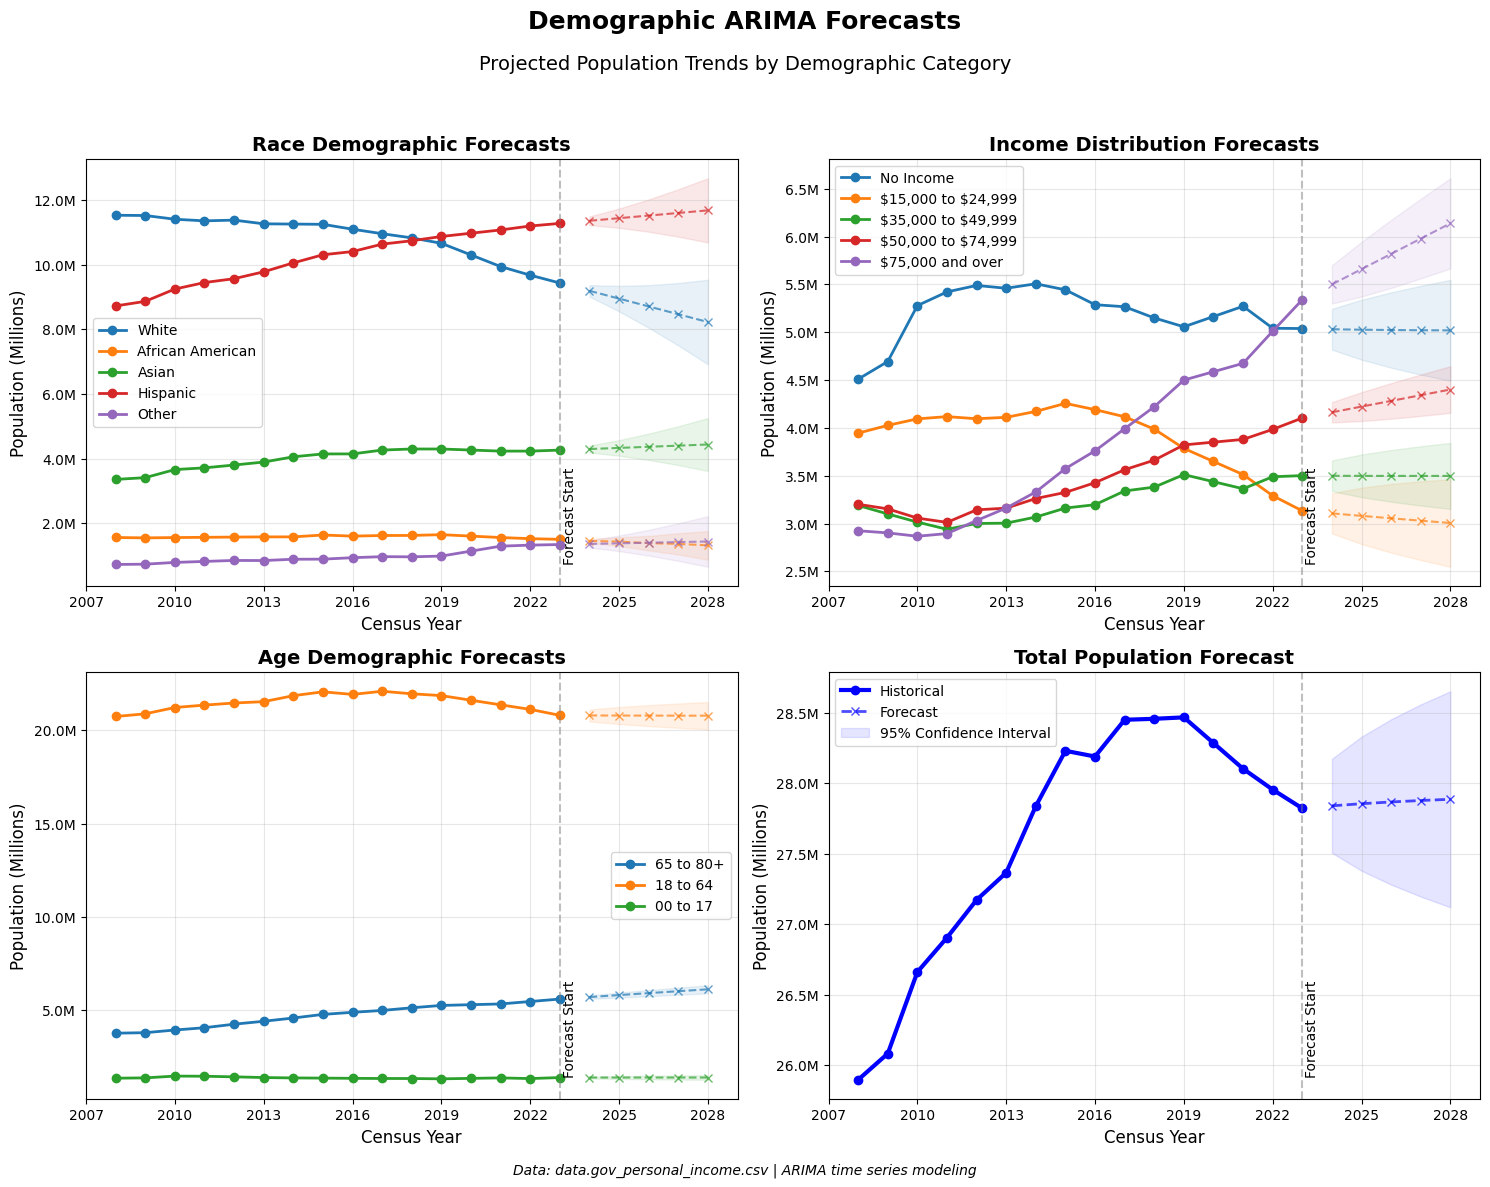


ARIMA Model Parameters:
White: ARIMA(0, 2, 1)
African American: ARIMA(2, 2, 2)
Asian: ARIMA(2, 2, 0)
Hispanic: ARIMA(2, 2, 0)
Other: ARIMA(1, 2, 0)
default: ARIMA(1, 1, 1)
Loaded data with 15360 rows and 7 columns


In [7]:
file_path = "./data/out/data.gov_personal_income.csv"
analyze_demographics(file_path)
save_fig_demographics(file_path, "report")